# Coral Project
This project seeks to find trends in coral populations in the Pacific Ocean over the course of a NOAA study spanning from 2005-2012. I try to model coral populations using several regression techniques as well.

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import math 

In [3]:
df = pd.read_csv(r'C:\Users\harr1\Downloads\V0_BENT_LPI.csv')                                               #######
print (df.info())

c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229198 entries, 0 to 229197
Data columns (total 31 columns):
OBJECTID           229198 non-null int64
ROUNDID            229198 non-null int64
MISSIONID          229198 non-null object
REGION_NAME        229198 non-null object
ISLAND             229198 non-null object
SITEVISITID        229198 non-null int64
SITE               229198 non-null object
LATITUDE           229184 non-null float64
LONGITUDE          229184 non-null float64
REEF_ZONE          229198 non-null object
DEPTH_BIN          224864 non-null object
MIN_Z_M            209939 non-null float64
MAX_Z_M            209939 non-null float64
DATE_              229198 non-null object
OBS_YEAR           229198 non-null int64
LPITRANSECTRUN     229198 non-null int64
DIVER              229198 non-null object
MINDEPTH           180610 non-null float64
MAXDEPTH           182488 non-null float64
METHODCODE         229198 non-null int64
CALIBRATION        99078 non-null float64
TRANNUM

In [4]:
#Drop columns that are not important                                                                                                       
df = df.drop(['MINDEPTH', 'MAXDEPTH', 'CALIBRATION', 'MIN_Z_M', 'MAX_Z_M', 'OBJECTID', 'ROUNDID',
             'TRANNUM', 'LPI_SEG', 'METHODCODE'], axis=1)
#No information about how 2009 data collected, so drop this year from dataset
df = df[df['OBS_YEAR']!=2009]
#Only interested in corals, so eliminate anything that is not a coral
df = df[df['BENTHICCATEGORY'] == 'CORL']
#Drop nulls
df= df.dropna()

In [5]:
#Get dummies for island, region, family, diver, and reef zone     

# from sklearn.preprocessing import LabelEncoder
# df['families'] = LabelEncoder().fit_transform(df['FAMILY'])
# df['islands'] = LabelEncoder().fit_transform(df['ISLAND'])
# df['reefs'] = LabelEncoder().fit_transform(df['REEF_ZONE'])
# df['regions'] = LabelEncoder().fit_transform(df['REGION_NAME'])

df = pd.concat([df, df['FAMILY'].str.get_dummies(sep=',')], axis=1)
df = pd.concat([df, df['ISLAND'].str.get_dummies(sep=',')], axis=1)
df = pd.concat([df, df['REEF_ZONE'].str.get_dummies(sep=',')], axis=1)
df = pd.concat([df, df['REGION_NAME'].str.get_dummies(sep=',')], axis=1)

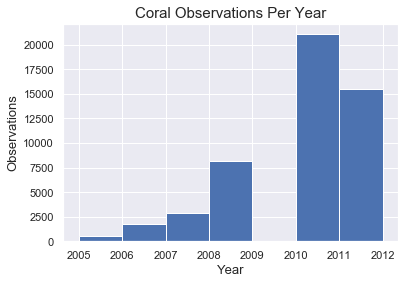

In [6]:
#How many observations were taken per year? This does not count the total number of corals, just the observations of them.
#For example, if a diver found 2 corals at the same location, it counts as one in this graph
plt.hist(df['OBS_YEAR'], bins = 7)
plt.title('Coral Observations Per Year', fontsize = 15)
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Observations', fontsize =13)
plt.show()

In [7]:
#convert date from dd-ABREV-yyyy to yyyymmdd                                                                     ####

from datetime import datetime

df['Date']= [datetime.strptime(x, '%d-%b-%y').strftime('%Y-%m-%d') for x in df['DATE_']]

df['Month'] = [datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m') for x in df['Date']]

for x in df['Date']:
    x.replace("-", "")
    
for y in df['Month']:
    y.replace("-", "")
    

#Sort values as they are out of order in the original dataframe
df_sorted = df.sort_values('Date')




In [8]:
#Calculate the Transects taken per day
#Calculate the total number of corals found per day

df_sorted['Transect/day'] = df_sorted['LPITRANSECTRUN'].groupby(df_sorted['Date']).transform('nunique')                         ######
df_sorted['Coral/day'] = df_sorted['COUNT'].groupby(df_sorted['Date']).transform('sum')


In [9]:
# Transforming data based on samples taken during observations                                     

# Since 2005-2008 data was collected every 50cm and 2010-2012 data collected every 20cm, we need to standardize the data
# 2005-2008 data multiplied by 2.5 as there were 2.5X fewer observations made per transect. Data divided by number 
# of transects taken per day to standardize how many corals found per meter


df_2005 = df_sorted[df_sorted['Date']<='2008-12-31']
df_2010 = df_sorted[df_sorted['Date']>'2009-12-31']


df_2005['Coral/m']= (((df_2005['Coral/day']*2.5)/df_2005['Transect/day'])/25)
df_2010['Coral/m']= (((df_2010['Coral/day'])/df_2010['Transect/day'])/25)



c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [10]:
#Add the transformed data back into the sorted dataframe
df_sorted= pd.concat([df_2005, df_2010], axis=0)
print (df_sorted['Coral/m'])

1         0.875000
98        0.875000
100       0.875000
105       0.875000
11        0.875000
            ...   
211851    1.266667
211852    1.266667
211854    1.266667
211863    1.266667
211880    1.266667
Name: Coral/m, Length: 49846, dtype: float64


## General Trends: Coral population over time

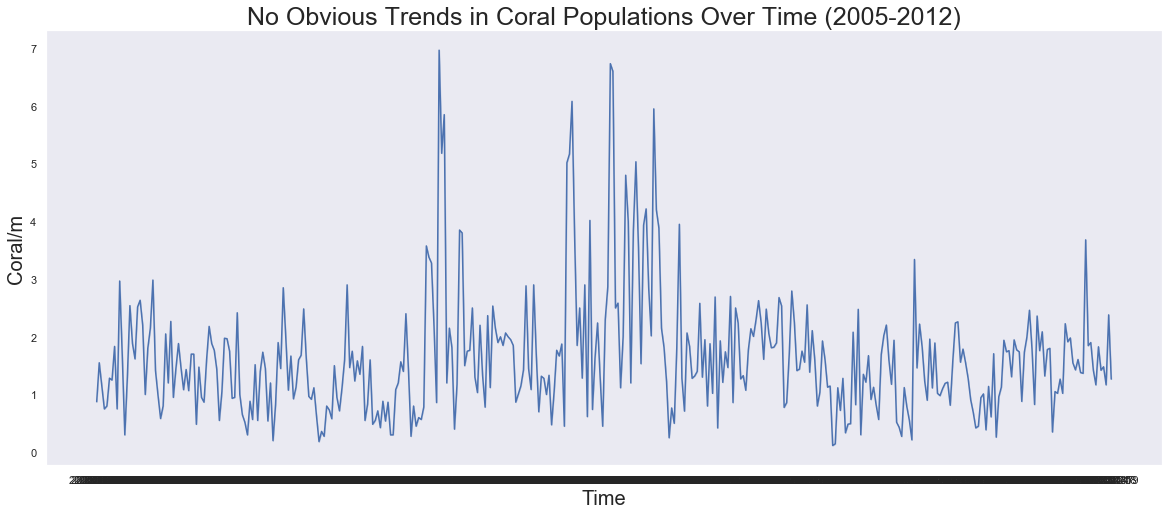

In [19]:
#Plotting the coral population over the course of the study

plt.figure(figsize=(20, 8))
ax = sns.lineplot(x= 'Date', y= 'Coral/m', data = df_sorted)
sns.axes_style("whitegrid")
ax.grid(False)
plt.title('No Obvious Trends in Coral Populations Over Time (2005-2012)', fontsize = 25)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Coral/m', fontsize = 20)
plt.show()




In [8]:
!pip install hvplot arrow bokeh -U

Requirement already up-to-date: hvplot in c:\users\harr1\anaconda3\lib\site-packages (0.4.0)
  Running setup.py bdist_wheel for bokeh: started
  Running setup.py bdist_wheel for bokeh: still running...
  Running setup.py bdist_wheel for bokeh: finished with status 'done'
  Stored in directory: C:\Users\harr1\AppData\Local\pip\Cache\wheels\96\8c\18\ab51f7028839c79738fc7b21c7d660f3d59e7748eb903fbe15
Successfully built bokeh
  Found existing installation: arrow 0.13.1
    Uninstalling arrow-0.13.1:
      Successfully uninstalled arrow-0.13.1
  Found existing installation: bokeh 1.1.0
    Uninstalling bokeh-1.1.0:
      Successfully uninstalled bokeh-1.1.0


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
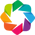

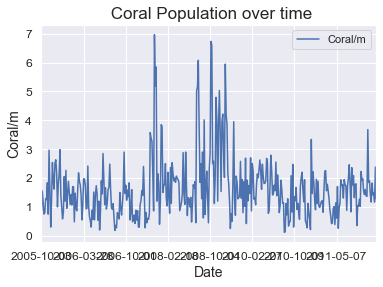

In [25]:
from bokeh.plotting import figure
import arrow
import hvplot
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')


df_for_plotting = df_sorted.copy()

df_for_plotting = df_for_plotting.drop_duplicates('Date')

#df_for_plotting.hvplot.scatter(x='Date', y='Coral/m', by='REGION_NAME', title = 'Coral Populations Vary by Region and Year')


p = df_for_plotting.plot.line(x='Date', y='Coral/m', by='regions', fontsize = 12)
p = plt.title(' Coral Population over time', fontsize = 17)
p = plt.xlabel('Date', fontsize = 14)
p = plt.ylabel('Coral/m', fontsize = 14)


# Global plots

In [13]:
df_short = df_sorted.groupby(['Date'])['Coral/m','LATITUDE','LONGITUDE'].mean()

import plotly.graph_objects as go

import pandas as pd


fig = go.Figure(data=go.Scattergeo(
        lon = df_short['LONGITUDE'],
        lat = df_short['LATITUDE'],

        mode = 'markers',
        marker_color = df_short['Coral/m'],
        ))

fig.update_layout(
        title = 'Coral/m from 2005 to 2012'
    )
fig.show()


In [12]:

fig = go.Figure(data=go.Scattergeo(

        lon = df_short['LONGITUDE'],
        lat = df_short['LATITUDE'],
#         text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df_short['Coral/m'],
            cmax = df_short['Coral/m'].max(),
             colorbar_title="Coral/m"
        )))

fig.update_layout(
        title = 'Coral/m',
        geo = dict(

            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

## Coral Populations VS Region over time

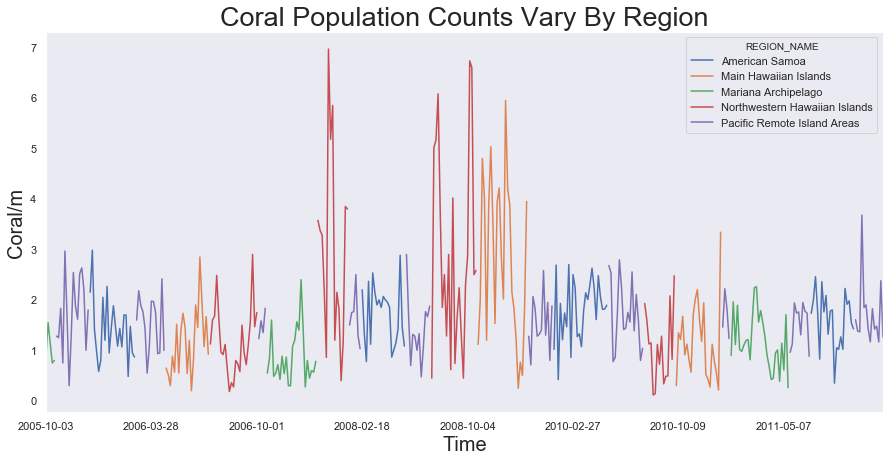

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
df_sorted.groupby(['Date','REGION_NAME'])['Coral/m'].mean().unstack().plot(ax=ax)
plt.title('Coral Population Counts Vary By Region', fontsize=27)
ax.grid(False)
plt.ylabel('Coral/m', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.show()

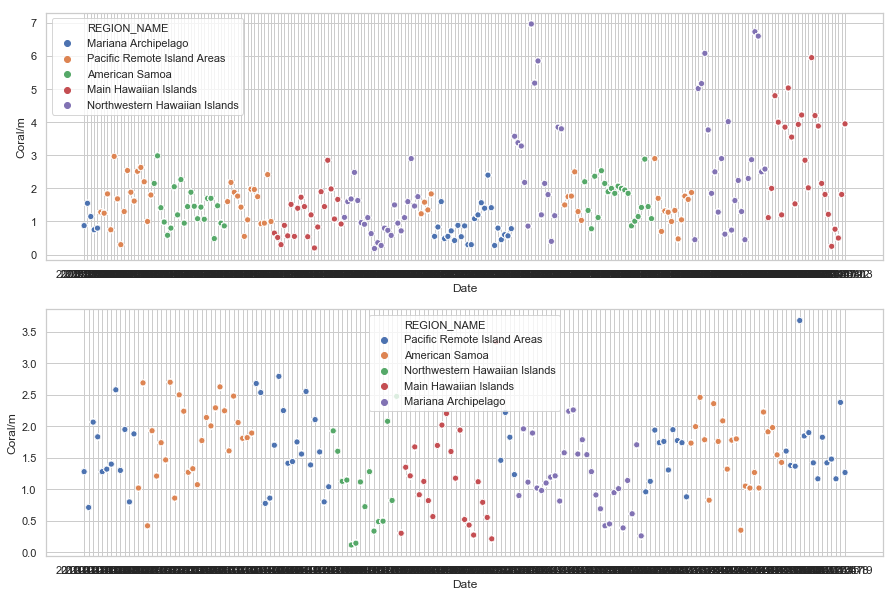

In [14]:
#Plotting Coral Population per region, breaking the data down into the two separate studies

sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
ax = sns.scatterplot(x='Date', y='Coral/m', hue='REGION_NAME', data=df_2005)
plt.title = ('Coral/day WITH REGIONS 2005')

plt.subplot(2,1,2)
ax = sns.scatterplot(x='Date', y='Coral/m', hue='REGION_NAME', data=df_2010)

plt.title = ('Coral/day WITH REGIONS 2010')


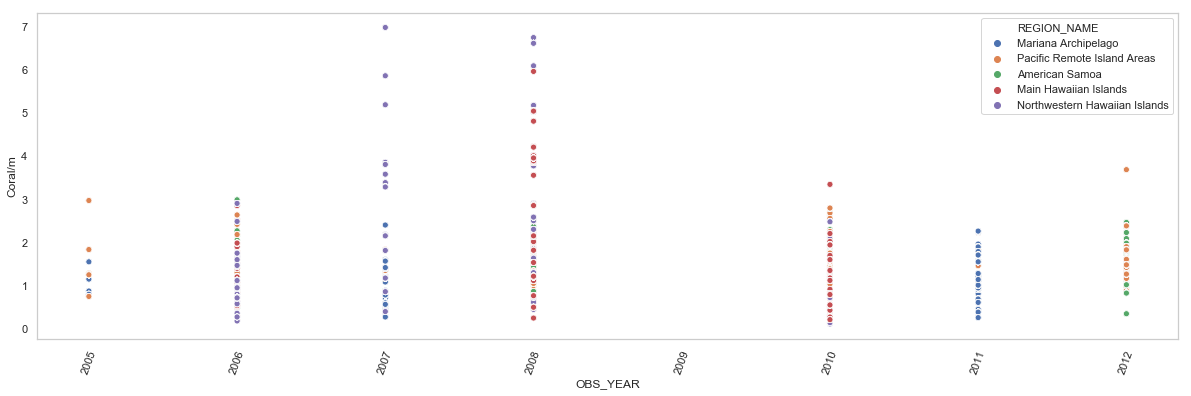

In [15]:
#Coral population per region per year, scatterplot
sns.set_style("whitegrid")
plt.figure(figsize=(45,6))

plt.subplot(1,2,1)
ax = sns.scatterplot(x='OBS_YEAR', y='Coral/m', hue='REGION_NAME', data=df_sorted)
ax.grid(False)


plt.xticks(rotation=70)
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
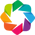

:NdOverlay   [REGION_NAME]
   :Scatter   [Date]   (Coral/day)

In [17]:
import arrow
import hvplot
import hvplot.pandas
import holoviews as hv


hv.extension('bokeh')


df_for_plotting = df_sorted.copy()

df_for_plotting = df_for_plotting.drop_duplicates('Date')

df_for_plotting.hvplot.scatter(x='Date', y='Coral/day', by='REGION_NAME')

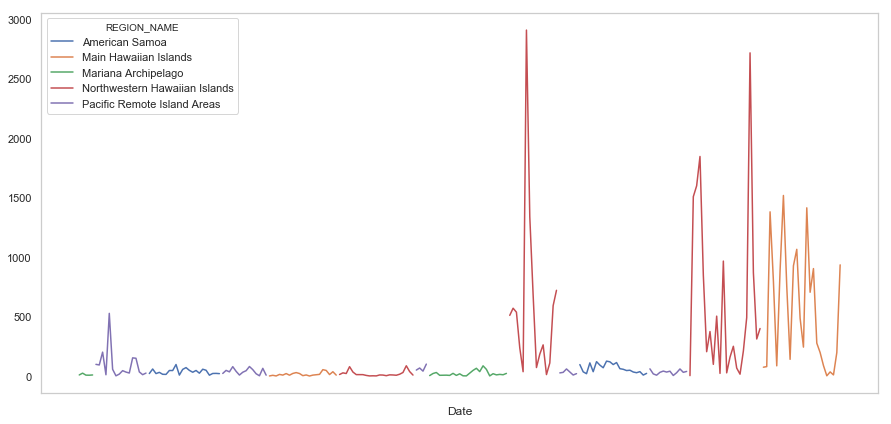

<Figure size 1080x504 with 0 Axes>

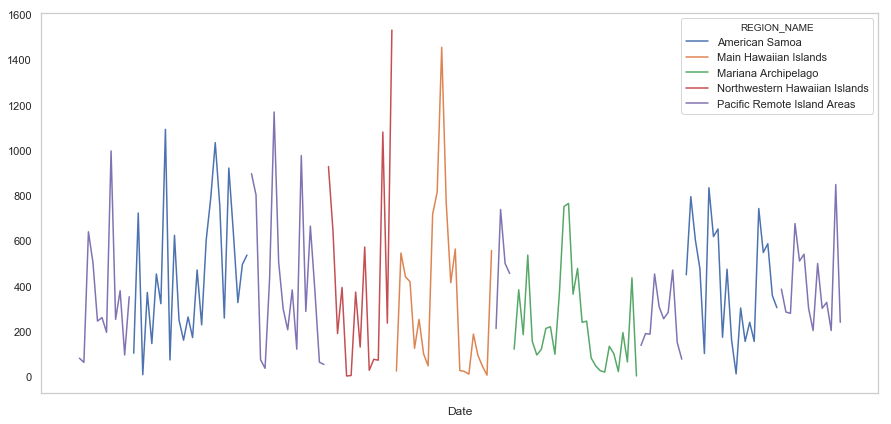

<Figure size 1080x504 with 0 Axes>

In [18]:
#Groupby Region and plot that over time


fig, ax = plt.subplots(figsize=(15,7))

plt.figure(figsize=(15,7))

df_2005.groupby(['Date','REGION_NAME']).sum()['Coral/m'].unstack().plot(ax=ax, label='2005')
ax.grid(False)
plt.show()

fig, ax = plt.subplots(figsize=(15,7))
plt.figure(figsize=(15,7))


df_2010.groupby(['Date','REGION_NAME']).sum()['Coral/m'].unstack().plot(ax=ax, label='2010')
ax.grid(False)
plt.show()

## Coral Population vs Diver over time

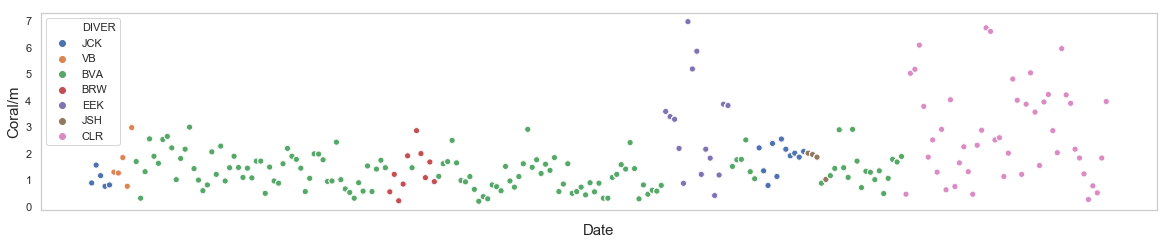

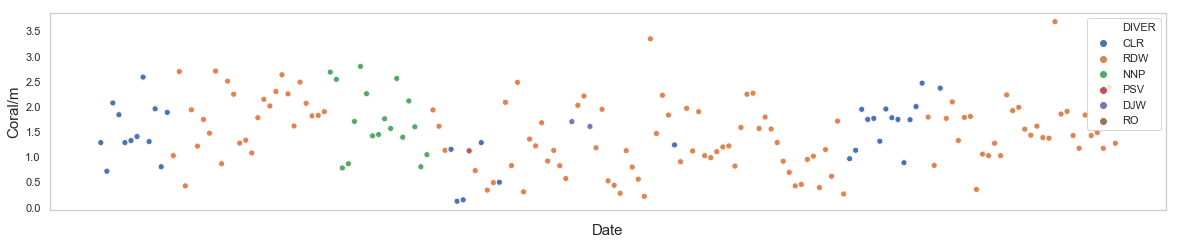

In [24]:
#Plotting Coral Population per diver, breaking the data down into the two separate studies

sns.set_style("whitegrid")
plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
ax = sns.scatterplot(x='Date', y='Coral/m', hue='DIVER', data=df_2005)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Coral/m', fontsize = 15)
#plt.title('Coral/m/day with Divers 2005-2008', fontsize = 20)
ax.grid(False)
ax.set(xticklabels=[])


plt.show()


sns.set_style("whitegrid")
plt.figure(figsize=(20,8))

plt.subplot(2,1,2)
ax = sns.scatterplot(x='Date', y='Coral/m', hue='DIVER', data=df_2010)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Coral/m', fontsize = 15)
#plt.title('Coral/m/day with Divers 2010-2012', fontsize = 20)
ax.grid(False)
ax.set(xticklabels=[])


plt.show()


In [ ]:
#Coral population per diver over course of whole study

sns.set_style("whitegrid")
plt.figure(figsize=(20,8))

ax = sns.scatterplot(x='Date', y='Coral/m', hue='DIVER', data=df_sorted)
plt.title('Coral Population Counts Vary Based on Diver', fontsize = 25)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Coral/m', fontsize = 20)
ax.grid(False)
ax.set(xticklabels=[])
plt.show()


In [ ]:
from bokeh.plotting import figure

hv.extension('bokeh')


df_for_plotting = df_sorted.copy()

#df_for_plotting = df_for_plotting.drop_duplicates('Date')

df_for_plotting.hvplot.scatter(x='Date', y='Coral/m', by='DIVER', title = 'Coral Populations Vary by Diver and Year')


## Coral Populations vs Coral Family over time

In [ ]:
#Coral Populations vs family, lineplot
fig, ax = plt.subplots(figsize=(15,7))
plt.figure(figsize=(15,7))
df_sorted.groupby(['Date','FAMILY']).mean()['Coral/m'].unstack().plot(ax=ax, label='upper right')
plt.show()

## Feature Selection

In [58]:
data = df[['OBS_YEAR',
           'LATITUDE', 
           'LONGITUDE', 
           #Reef zone
           'Forereef', 'Lagoon', 'Protected Slope', 'Backreef',
           #Families
           'Acroporidae', 'Agariciidae', 'Pocilloporidae', 'Faviidae', 'Siderastreidae',
 'Poritidae', 'Merulinidae', 'Milleporidae', 'Dendrophylliidae', 'Fungiidae',
 'Mussidae', 'Oculinidae', 'Pectiniidae', 'Helioporidae', 'Astrocoeniidae',
 'Caryophylliidae', 'Stylasteridae',
           #Divers
           'BVA', 'JCK', 'JSH', 'CLR', 'RDW', 'RO',
           #Islands
           'Guam', 'Santa Rosa', 'Wake', 'Hawaii', 'Kauai', 'Kaula', 'Lanai',
       'Lehua', 'Maui', 'Molokai', 'Niihau', 'Oahu', 'French Frigate',
       'Kure', 'Laysan', 'Lisianski', 'Maro', 'Midway', 'Necker',
       'Pearl & Hermes', 'Baker', 'Howland', 'Jarvis', 'Johnston',
       'Kingman', 'Palmyra', 'Ofu & Olosega', 'Rose', 'Swains', 'Tau',
       'Tutuila', 'Agrihan', 'Aguijan', 'Alamagan', 'Asuncion',
       'Farallon de Pajaros', 'Guguan', 'Maug', 'Pagan', 'Rota', 'Saipan',
       'Sarigan', 'Tinian',
           #Regions
           'Mariana Archipelago', 'Pacific Remote Island Areas',
       'Main Hawaiian Islands', 'Northwestern Hawaiian Islands',
       'American Samoa'
          ]]
target = df_sorted['Coral/m']
           

                

In [59]:
data_names=['OBS_YEAR',
           'LATITUDE', 
           'LONGITUDE', 
           #Reef zone
           'Forereef', 'Lagoon', 'Protected Slope', 'Backreef',
           #Families
           'Acroporidae', 'Agariciidae', 'Pocilloporidae', 'Faviidae', 'Siderastreidae',
 'Poritidae', 'Merulinidae', 'Milleporidae', 'Dendrophylliidae', 'Fungiidae',
 'Mussidae', 'Oculinidae', 'Pectiniidae', 'Helioporidae', 'Astrocoeniidae',
 'Caryophylliidae', 'Stylasteridae',
           #Divers
           'BVA', 'JCK', 'JSH', 'CLR', 'RDW', 'RO',
           #Islands
           'Guam', 'Santa Rosa', 'Wake', 'Hawaii', 'Kauai', 'Kaula', 'Lanai',
       'Lehua', 'Maui', 'Molokai', 'Niihau', 'Oahu', 'French Frigate',
       'Kure', 'Laysan', 'Lisianski', 'Maro', 'Midway', 'Necker',
       'Pearl & Hermes', 'Baker', 'Howland', 'Jarvis', 'Johnston',
       'Kingman', 'Palmyra', 'Ofu & Olosega', 'Rose', 'Swains', 'Tau',
       'Tutuila', 'Agrihan', 'Aguijan', 'Alamagan', 'Asuncion',
       'Farallon de Pajaros', 'Guguan', 'Maug', 'Pagan', 'Rota', 'Saipan',
       'Sarigan', 'Tinian',
           #Regions
           'Mariana Archipelago', 'Pacific Remote Island Areas',
       'Main Hawaiian Islands', 'Northwestern Hawaiian Islands',
       'American Samoa'
          ]

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=0)

In [60]:
RandForest= ensemble.RandomForestRegressor()

RandForest.fit(data,target)



C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:


RandForest.feature_importances_
RandForest_ft_series = pd.Series(data=RandForest.feature_importances_, index=data.columns)
###################################
sorted_series = RandForest_ft_series.sort_values(ascending = False)
sorted_series

OBS_YEAR                       3.524456e-01
LATITUDE                       2.824041e-01
LONGITUDE                      2.048863e-01
Lanai                          2.325921e-02
Lagoon                         1.852597e-02
Pacific Remote Island Areas    1.584892e-02
Pearl & Hermes                 1.504137e-02
Poritidae                      1.422978e-02
Niihau                         8.790552e-03
CLR                            8.732867e-03
Tau                            6.544104e-03
American Samoa                 4.888537e-03
Wake                           4.248866e-03
BVA                            3.943989e-03
Tutuila                        3.260047e-03
Forereef                       2.933352e-03
Oahu                           2.792678e-03
Swains                         2.517443e-03
Baker                          2.357976e-03
JCK                            1.792817e-03
RDW                            1.750897e-03
Protected Slope                1.682235e-03
Acroporidae                    1

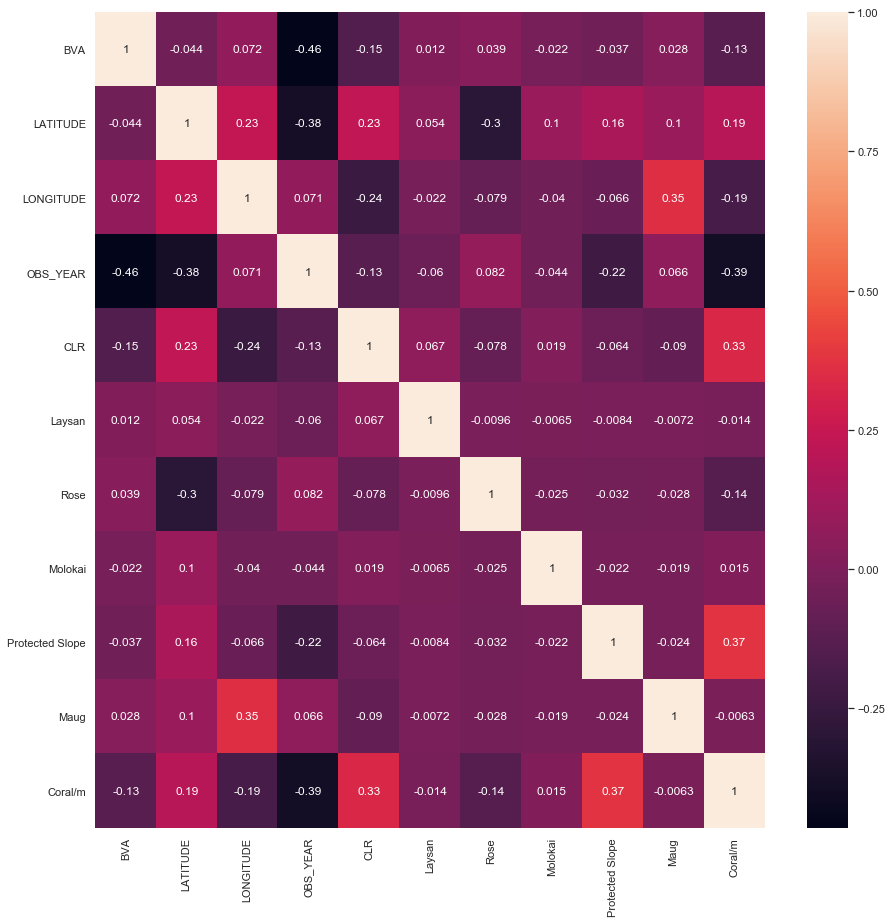

In [62]:

corrmat = df_sorted.corr()
features=['BVA', 'LATITUDE', 'LONGITUDE', 'OBS_YEAR', 'CLR', 'Laysan', 'Rose', 'Molokai', 'Protected Slope', 'Maug', 'Coral/m']
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df_sorted[features].corr(),annot=True)

## Models

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.tree import DecisionTreeRegressor



Since the regions, divers, and islands are of importance, I will sort by regions and apply the divers and islands present in those regions to the model

# Northwestern Hawaiian Islands

This is the most variable data set so it may show very different results than the other regions

In [64]:
df_NWHI= df_sorted[df_sorted['REGION_NAME']=='Northwestern Hawaiian Islands']

print(df_NWHI['ISLAND'].unique())
print(df_NWHI['DIVER'].unique())

['Necker' 'French Frigate' 'Maro' 'Laysan' 'Pearl & Hermes' 'Midway'
 'Kure' 'Lisianski']
['BVA' 'EEK' 'CLR' 'PSV' 'RDW']


In [65]:

data_NW = df_NWHI[[
                'LATITUDE', 
                'LONGITUDE', 
    'OBS_YEAR',
    'French Frigate', 'Kure', 'Laysan', 'Lisianski', 'Maro', 'Midway', 'Necker', 'Pearl & Hermes',
    'BVA', 'EEK', 'CLR', 'RDW', 'PSV']]

target_NW = df_NWHI['Coral/m']

data_NW_names=['LATITUDE', 
                'LONGITUDE', 
    'OBS_YEAR',
    'French Frigate', 'Kure', 'Laysan', 'Lisianski', 'Maro', 'Midway', 'Necker', 'Pearl & Hermes',
    'BVA', 'EEK', 'CLR', 'RDW', 'PSV']
############################################


In [66]:
from sklearn.model_selection import train_test_split

X_train_NW, X_test_NW, y_train_NW, y_test_NW = train_test_split(data_NW, target_NW, test_size=0.4, random_state=0)

# Pacific Remote Islands

These islands showed the smallest variability so the data may appear very different than NW Hawaii

In [67]:
df_PRI= df_sorted[df_sorted['REGION_NAME']=='Pacific Remote Island Areas']

print(df_PRI['ISLAND'].unique())
print(df_PRI['DIVER'].unique())

['Wake' 'Johnston' 'Howland' 'Baker' 'Jarvis' 'Palmyra' 'Kingman']
['VB' 'BVA' 'CLR' 'NNP' 'RDW']


In [68]:


data_PRI = df_PRI[[
                'LATITUDE', 
                'LONGITUDE',
    'OBS_YEAR',
                'Wake', 'Baker', 'Howland', 'Jarvis', 'Johnston', 'Kingman', 'Palmyra',
    'VB',  'BVA', 'CLR', 'NNP', 'RDW'       
          ]]
target_PRI = df_PRI['Coral/m']

data_PRI_names = ['LATITUDE', 
                'LONGITUDE',
    'OBS_YEAR',
                'Wake', 'Baker', 'Howland', 'Jarvis', 'Johnston', 'Kingman', 'Palmyra',
    'VB',  'BVA', 'CLR', 'NNP', 'RDW'       
          ]
############################################


In [69]:
from sklearn.model_selection import train_test_split

X_train_PRI, X_test_PRI, y_train_PRI, y_test_PRI = train_test_split(data_PRI, target_PRI, test_size=0.4, random_state=0)

## Linear Regressions: NW Hawaiian vs Pacific Remote

In [70]:

regr_NW = linear_model.LinearRegression()

regr_NW.fit(X_train_NW, y_train_NW)

cross_variable_NW=cross_val_score(regr_NW, X_train_NW, y_train_NW, cv=10)
print('Cross Validation: \n', cross_variable_NW)
print ('Mean:', np.mean(cross_variable_NW))
print ('std:',np.std(cross_variable_NW))
print('Coefficients: \n', regr_NW.coef_)
print('Intercept: \n', regr_NW.intercept_)
print ('Train score: \n', regr_NW.score(X_train_NW,y_train_NW))
print ('Test score: \n', regr_NW.score(X_test_NW,y_test_NW))


Cross Validation: 
 [0.67442242 0.66909428 0.67217283 0.69529243 0.67986557 0.66921908
 0.66531528 0.67521355 0.68110105 0.67492507]
Mean: 0.6756621560066
std: 0.007992264312574464
Coefficients: 
 [-6.26252104 -2.56135747 -1.3112952   1.81738311 -2.00142854 -2.15079652
 -3.83785036  1.42902115 -0.02138696  3.72435364  1.04070449 -3.97413817
 -0.09391988  1.24325655  1.28751083  1.53729067]
Intercept: 
 2357.6213317700126
Train score: 
 0.6772470329845929
Test score: 
 0.675419339988256


In [71]:

regr_PRI = linear_model.LinearRegression()

regr_PRI.fit(X_train_PRI, y_train_PRI)

cross_variable_PRI=cross_val_score(regr_PRI, X_train_PRI, y_train_PRI, cv=10)
print('Cross Validation: \n', cross_variable_PRI)
print ('Mean:', np.mean(cross_variable_PRI))
print ('std:',np.std(cross_variable_PRI))
print('Coefficients: \n', regr_PRI.coef_)
print('Intercept: \n', regr_PRI.intercept_)
print ('Train score: \n', regr_PRI.score(X_train_PRI,y_train_PRI))
print ('Test score: \n', regr_PRI.score(X_test_PRI,y_test_PRI))


Cross Validation: 
 [0.16059666 0.18659815 0.15805863 0.21015003 0.21525325 0.18054747
 0.18927735 0.16383513 0.21331026 0.19642283]
Mean: 0.1874049755598146
std: 0.020571540731665887
Coefficients: 
 [-5.54151216e+00 -3.53653033e+00 -1.12555751e-01  1.08187321e+03
 -2.37050673e+02 -2.33921087e+02 -1.81946905e+02 -1.20808045e+02
 -1.53120535e+02 -1.55025968e+02 -7.77684250e-02 -4.17210065e-01
 -1.85912182e-01  3.85279387e-01  2.95611286e-01]
Intercept: 
 -157.84282804940673
Train score: 
 0.19043966728577633
Test score: 
 0.20126936376999136


## Decision Tree 

Cross Validation: 
 [0.67132129 0.65511303 0.67380805 0.66483642 0.6904757  0.67257439
 0.67138066 0.67132269 0.69012293 0.66826831]
Mean: 0.6729223483902954
std: 0.010082652956257925
Train score: 
 0.674510487074158
Test score: 
 0.6659487284782906


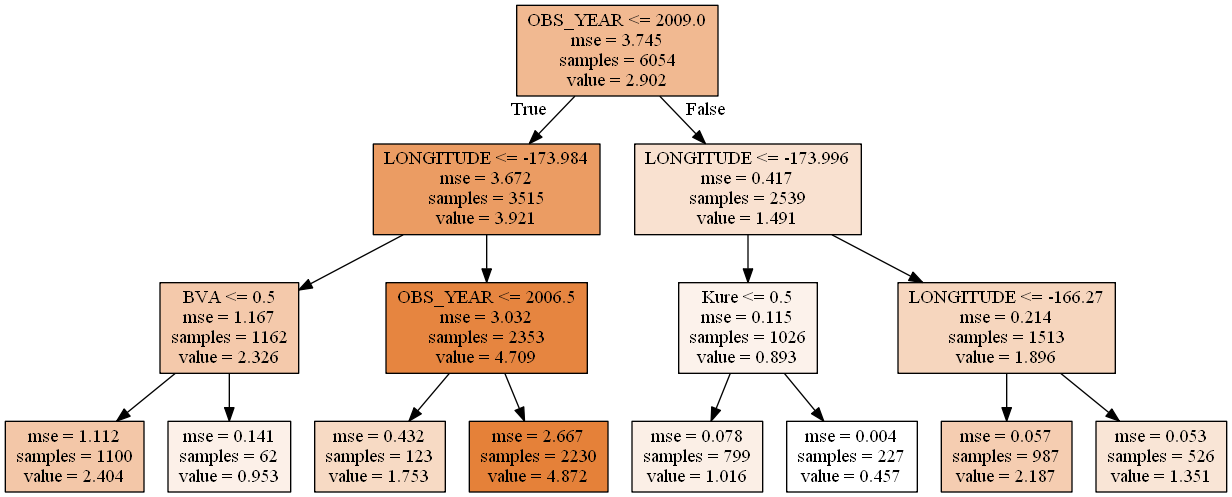

In [95]:
#NW Hawaii
tree_NW = DecisionTreeRegressor(max_depth=3)
tree_NW.fit(X_train_NW, y_train_NW)


dot_data = tree.export_graphviz(
    tree_NW, out_file=None,
    feature_names= data_NW_names,
    filled=True
)


cross_variable_NW=cross_val_score(tree_NW, X_train_NW, y_train_NW, cv=10)
print('Cross Validation: \n', cross_variable_NW)
print ('Mean:', np.mean(cross_variable_NW))
print ('std:',np.std(cross_variable_NW))
print ('Train score: \n', tree_NW.score(X_train_NW,y_train_NW))
print ('Test score: \n', tree_NW.score(X_test_NW,y_test_NW))


graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


Cross Validation: 
 [0.32448555 0.28291759 0.25789436 0.32648901 0.2783677  0.27346082
 0.30738767 0.28228257 0.27840101 0.30386483]
Mean: 0.2915551121543557
std: 0.02162166562940854
Train score: 
 0.3030101162226848
Test score: 
 0.30238381314866275


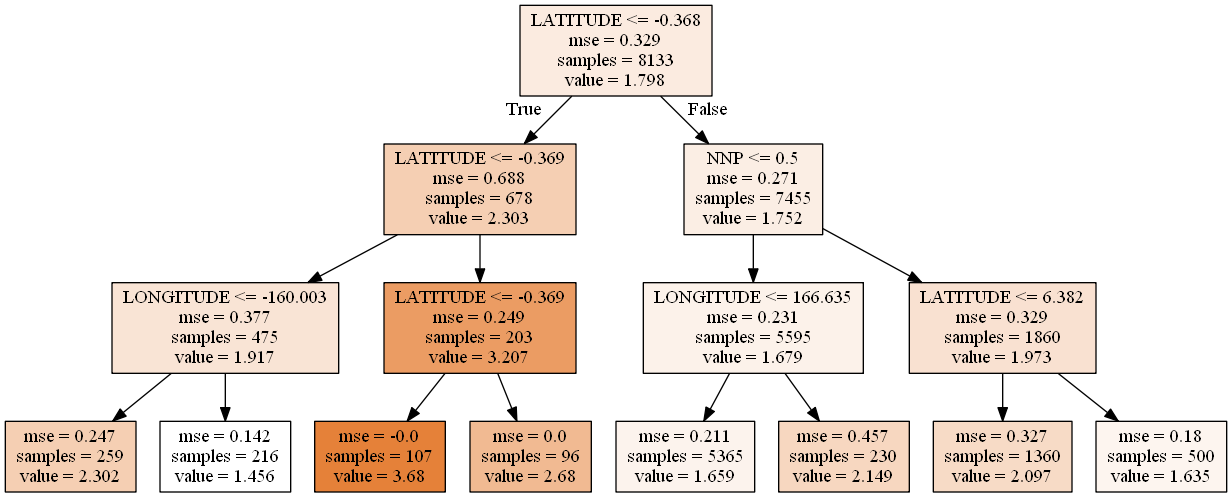

In [96]:
#Pacific Remote Islands    

tree_PRI = DecisionTreeRegressor(max_depth=3)
tree_PRI.fit(X_train_PRI, y_train_PRI)


dot_data = tree.export_graphviz(
    tree_PRI, out_file=None,
    feature_names= data_PRI_names,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

cross_variable_PRI=cross_val_score(tree_PRI, X_train_PRI, y_train_PRI, cv=10)
print('Cross Validation: \n', cross_variable_PRI)
print ('Mean:', np.mean(cross_variable_PRI))
print ('std:',np.std(cross_variable_PRI))
print ('Train score: \n', tree_PRI.score(X_train_PRI,y_train_PRI))
print ('Test score: \n', tree_PRI.score(X_test_PRI,y_test_PRI))


graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

   ## Random forest
    

In [76]:
#Random forest for all data
RandForest= ensemble.RandomForestRegressor()

RandForest.fit(X_train, y_train)

cross_variable=cross_val_score(RandForest, X_train, y_train, cv=10)
print('Cross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))
print ('Train score: \n', RandForest.score(X_train,y_train))
print ('Test score: \n', RandForest.score(X_test,y_test))

C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Validation: 
 [0.9012567  0.9051608  0.90984721 0.92362032 0.90496778 0.90595852
 0.90638026 0.92417925 0.9038117  0.89486337]
Mean: 0.9080045926361295
std: 0.00876815975907309
Train score: 
 0.9204640743647713
Test score: 
 0.9174549355691184


In [77]:
#Random forest for NW Hawaii

RandForest_NW= ensemble.RandomForestRegressor()

RandForest_NW.fit(X_train_NW,y_train_NW)

cross_variable_NW=cross_val_score(RandForest_NW, X_train_NW, y_train_NW, cv=10)
print('Cross Validation: \n', cross_variable_NW)
print ('Mean:', np.mean(cross_variable_NW))
print ('std:',np.std(cross_variable_NW))

print ('Train score: \n', RandForest_NW.score(X_train_NW,y_train_NW))
print ('Test score: \n', RandForest_NW.score(X_test_NW,y_test_NW))

C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Validation: 
 [0.99934579 0.99935139 0.99939967 0.99635453 0.99921788 0.99994455
 0.99747361 0.99933492 0.99973508 0.99984652]
Mean: 0.9990003938314909
std: 0.001097267343303329
Train score: 
 0.9999286991478795
Test score: 
 0.9997863643217256


In [78]:
#Random forest for PRI
RandForest_PRI= ensemble.RandomForestRegressor()

RandForest_PRI.fit(data_PRI,target_PRI)

cross_variable_PRI=cross_val_score(RandForest_PRI, X_train_PRI, y_train_PRI, cv=10)
print('Cross Validation: \n', cross_variable_PRI)
print ('Mean:', np.mean(cross_variable_PRI))
print ('std:',np.std(cross_variable_PRI))

print ('Train score: \n', RandForest_PRI.score(X_train_PRI,y_train_PRI))
print ('Test score: \n', RandForest_PRI.score(X_test_PRI,y_test_PRI))

C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross Validation: 
 [0.99270427 0.99761097 0.99448224 0.99961395 0.99973594 0.99848973
 0.99220458 0.99245392 0.99843505 0.99738676]
Mean: 0.9963117405391075
std: 0.002878157046517516
Train score: 
 0.9999338215029238
Test score: 
 0.9998615130496139


## Ridge Regression

Finding an appropriate alpha score

In [79]:
from sklearn.linear_model import RidgeCV

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data, target)
find_alpha.score(data, target)
print ('all data alpha:', find_alpha.alpha_)

find_alpha_NW = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_NW, target_NW)
find_alpha_NW.score(data_NW, target_NW)
print( 'NW alpha:', find_alpha_NW.alpha_)

find_alpha_PRI = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_PRI, target_PRI)
find_alpha_PRI.score(data_PRI, target_PRI)
print ('PRI alpha:', find_alpha_PRI.alpha_)



all data alpha: 0.01
NW alpha: 0.25
PRI alpha: 0.001


In [90]:
#with 'optimized alphas'

ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)
ridgeregr.fit(X_train, y_train)

cross_variable=cross_val_score(ridgeregr, X_train, y_train, cv=10)
print ('\nOptimized alphas')
print('Cross Validation, all data: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))
print ('Regression score, all data: \n', ridgeregr.score(X_train,y_train))

ridge_NW = linear_model.Ridge(alpha = .25 , fit_intercept = False)
ridge_NW.fit(X_train_NW, y_train_NW)

cross_variable_NW=cross_val_score(ridge_NW, X_train_NW, y_train_NW, cv=10)
print ('\nOptimized alphas')
print('Cross Validation, NW: \n', cross_variable_NW)
print ('Mean, NW:', np.mean(cross_variable_NW))
print ('STdv NW:',np.std(cross_variable_NW))
print ('NW train score: \n', ridge_NW.score(X_train_NW,y_train_NW))
print ('NW test score: \n', ridge_NW.score(X_test_NW,y_test_NW))

ridge_PRI = linear_model.Ridge(alpha = .001 , fit_intercept = False)
ridge_PRI.fit(X_train_PRI, y_train_PRI)

cross_variable_PRI=cross_val_score(ridge_PRI, X_train_PRI, y_train_PRI, cv=10)
print ('\nOptimized alphas')
print('Cross Validation, PRI: \n', cross_variable_PRI)
print ('Mean, PRI:', np.mean(cross_variable_PRI))
print ('STdv PRI:',np.std(cross_variable_PRI))
print ('PRI train score: \n', ridge_PRI.score(X_train_PRI,y_train_PRI))
print ('PRI test score: \n', ridge_PRI.score(X_test_PRI,y_test_PRI))


Optimized alphas
Cross Validation, all data: 
 [0.42401301 0.36536357 0.4234031  0.40477663 0.38905833 0.42064172
 0.39385509 0.42120259 0.38907769 0.39528962]
Mean all data: 0.4026681350346289
Stdv all data: 0.01857480560176175
Regression score, all data: 
 0.4072156501845336

Optimized alphas
Cross Validation, NW: 
 [0.56322611 0.58276689 0.56937322 0.6152965  0.58805855 0.5927361
 0.57626978 0.59144189 0.60039719 0.57267283]
Mean, NW: 0.5852239066851181
STdv NW: 0.01488828697715432
NW train score: 
 0.5887194754011811
NW test score: 
 0.5862402681590297

Optimized alphas
Cross Validation, PRI: 
 [0.13333011 0.16017747 0.14381076 0.17901203 0.18717118 0.15468579
 0.1537438  0.14227602 0.18870057 0.16094242]
Mean, PRI: 0.16038501376188252
STdv PRI: 0.018104655710425847
PRI train score: 
 0.16417340399745095
PRI test score: 
 0.17572020841937874


In [91]:
#With default alpha: Lower scores, higher stdev

ridgeregr = linear_model.Ridge(alpha = 10, fit_intercept = False)
ridgeregr.fit(X_train, y_train)

cross_variable=cross_val_score(ridgeregr, X_train, y_train, cv=10)
print('Default alpha')
print('Cross Validation, all data: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))
print ('Regression score, all data: \n', ridgeregr.score(X_train,y_train))

ridge_NW = linear_model.Ridge(alpha = 10 , fit_intercept = False)
ridge_NW.fit(X_train_NW, y_train_NW)

cross_variable_NW=cross_val_score(ridge_NW, X_train_NW, y_train_NW, cv=10)
print('\nDefault alpha')
print('Cross Validation, NW: \n', cross_variable_NW)
print ('Mean, NW:', np.mean(cross_variable_NW))
print ('STdv NW:',np.std(cross_variable_NW))
print ('NW train score: \n', ridge_NW.score(X_train_NW,y_train_NW))
print ('NW test score: \n', ridge_NW.score(X_test_NW,y_test_NW))

ridge_PRI = linear_model.Ridge(alpha = 10 , fit_intercept = False)
ridge_PRI.fit(data_PRI, target_PRI)

cross_variable_PRI=cross_val_score(ridge_PRI, data_PRI, target_PRI, cv=10)
print('\nDefault alpha')
print('Cross Validation, PRI: \n', cross_variable_PRI)
print ('Mean, PRI:', np.mean(cross_variable_PRI))
print ('STdv PRI:',np.std(cross_variable_PRI))
print ('PRI train score: \n', ridge_PRI.score(X_train_PRI,y_train_PRI))
print ('PRI test score: \n', ridge_PRI.score(X_test_PRI,y_test_PRI))

Default alpha
Cross Validation, all data: 
 [0.41003637 0.35494792 0.40959546 0.39346439 0.37673217 0.40943018
 0.38080882 0.40926206 0.37694186 0.38003688]
Mean all data: 0.3901256093244675
Stdv all data: 0.018179057948072463
Regression score, all data: 
 0.39341063834449813

Default alpha
Cross Validation, NW: 
 [0.51492951 0.53610086 0.52601031 0.57343805 0.5532558  0.55935458
 0.53401931 0.54517609 0.55566928 0.52836936]
Mean, NW: 0.5426323151041917
STdv NW: 0.016976251057712107
NW train score: 
 0.5462475384004128
NW test score: 
 0.5432294602666632

Default alpha
Cross Validation, PRI: 
 [-0.08239411 -0.18330573  0.06461319 -0.40388628 -0.28429361 -1.12704613
 -0.41950803 -3.61552439 -0.02726234 -0.00701087]
Mean, PRI: -0.6085618297533907
STdv PRI: 1.0537583004115179
PRI train score: 
 0.14377802016835528
PRI test score: 
 0.15784698766616645


## Lasso Regression

In [94]:
from sklearn.linear_model import LassoCV

find_lass_alpha = LassoCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data, target)
find_lass_alpha.score(data, target)
print ('all data alpha:', find_lass_alpha.alpha_)

find_lass_alpha_NW = LassoCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_NW, target_NW)
find_lass_alpha_NW.score(X_train_NW, y_train_NW)
print ('all NW alpha:', find_lass_alpha_NW.alpha_)

find_lass_alpha_PRI = LassoCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_PRI, target_PRI)
find_lass_alpha_PRI.score(X_train_PRI, y_train_PRI)
print ('all data alpha:', find_lass_alpha_PRI.alpha_)

C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


all data alpha: 0.5


C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase

all NW alpha: 0.02
all data alpha: 0.02


C:\Users\harr1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [92]:
#Lasso Regression with default alphas

lass = linear_model.Lasso(alpha=.25)
lass.fit(X_train, y_train)
cvscore_lass=cross_val_score(lass, X_train, y_train, cv=10)


print('\nDefault alpha')
print('Cross Validation, all data: \n', cvscore_lass)
print ('Mean all data:', np.mean(cvscore_lass))
print ('Stdv all data:', np.std(cvscore_lass))
print ('Regression score, all data: \n', lass.score(X_train,y_train))

lass_NW = linear_model.Lasso(alpha=.25)
lass_NW.fit(X_train_NW, y_train_NW)
cvscore_lass_NW=cross_val_score(lass_NW, X_train_NW, y_train_NW, cv=10)

print('\nDefault alpha')
print('Cross Validation, NW Hawaii: \n', cvscore_lass_NW)
print ('Mean NW Hawaii:', np.mean(cvscore_lass_NW))
print ('Stdv NW Hawaii:', np.std(cvscore_lass_NW))
print ('NW train score: \n', lass_NW.score(X_train_NW,y_train_NW))
print ('NW test score: \n', lass_NW.score(X_test_NW,y_test_NW))

lass_PRI = linear_model.Lasso(alpha=.25)
lass_PRI.fit(X_train_PRI, y_train_PRI)
cvscore_lass_PRI=cross_val_score(lass_PRI,X_train_PRI, y_train_PRI, cv=10)


print('\n Cross Validation, PRI: \n', cvscore_lass_PRI)
print ('Mean, PRI:', np.mean(cvscore_lass_PRI))
print ('STdv PRI:',np.std(cvscore_lass_PRI))
print ('PRI train score: \n', lass_PRI.score(X_train_PRI,y_train_PRI))
print ('PRI test score: \n', lass_PRI.score(X_test_PRI,y_test_PRI))




Default alpha
Cross Validation, all data: 
 [0.20618501 0.18376079 0.20535764 0.19880438 0.19664095 0.21080249
 0.19985304 0.19772342 0.20426826 0.18640495]
Mean all data: 0.1989800920530822
Stdv all data: 0.008111244058367571
Regression score, all data: 
 0.19966386917764534

Default alpha
Cross Validation, NW Hawaii: 
 [0.34768425 0.4691707  0.35411453 0.43266664 0.37556619 0.37157681
 0.36942873 0.38699582 0.39083381 0.3698226 ]
Mean NW Hawaii: 0.38678600769388616
Stdv NW Hawaii: 0.035286411885337904
NW train score: 
 0.38689743984391917
NW test score: 
 0.3876919357529002

 Cross Validation, PRI: 
 [0.02698132 0.0339409  0.03021782 0.02798594 0.03535681 0.03516739
 0.03197643 0.02867246 0.03822356 0.04372354]
Mean, PRI: 0.03322461625425679
STdv PRI: 0.004917254055582106
PRI train score: 
 0.03479846555876509
PRI test score: 
 0.038774098390154554


In [93]:
#Lasso Regression with 'optimized' alphas

lass = linear_model.Lasso(alpha=.5)
lass.fit(X_train, y_train)
cvscore_lass=cross_val_score(lass, X_train, y_train, cv=10)


print('\nDefault alpha')
print('Cross Validation, all data: \n', cvscore_lass)
print ('Mean all data:', np.mean(cvscore_lass))
print ('Stdv all data:', np.std(cvscore_lass))
print ('Regression score, all data: \n', lass.score(X_train,y_train))

lass_NW = linear_model.Lasso(alpha=.02)
lass_NW.fit(X_train_NW, y_train_NW)
cvscore_lass_NW=cross_val_score(lass_NW, X_train_NW, y_train_NW, cv=10)

print('\nDefault alpha')
print('Cross Validation, NW Hawaii: \n', cvscore_lass_NW)
print ('Mean NW Hawaii:', np.mean(cvscore_lass_NW))
print ('Stdv NW Hawaii:', np.std(cvscore_lass_NW))
print ('NW train score: \n', lass_NW.score(X_train_NW,y_train_NW))
print ('NW test score: \n', lass_NW.score(X_test_NW,y_test_NW))

lass_PRI = linear_model.Lasso(alpha=.02)
lass_PRI.fit(X_train_PRI, y_train_PRI)
cvscore_lass_PRI=cross_val_score(lass_PRI,X_train_PRI, y_train_PRI, cv=10)


print('\n Cross Validation, PRI: \n', cvscore_lass_PRI)
print ('Mean, PRI:', np.mean(cvscore_lass_PRI))
print ('STdv PRI:',np.std(cvscore_lass_PRI))
print ('PRI train score: \n', lass_PRI.score(X_train_PRI,y_train_PRI))
print ('PRI test score: \n', lass_PRI.score(X_test_PRI,y_test_PRI))




Default alpha
Cross Validation, all data: 
 [0.15889064 0.13921202 0.15665614 0.15355752 0.14822064 0.16200596
 0.15324874 0.14736934 0.15902588 0.14130749]
Mean all data: 0.15194943755249865
Stdv all data: 0.007322508324559024
Regression score, all data: 
 0.15253596875202047

Default alpha
Cross Validation, NW Hawaii: 
 [0.61146024 0.61099207 0.60852561 0.63015891 0.62581998 0.60989722
 0.6092457  0.61309936 0.62044187 0.61169153]
Mean NW Hawaii: 0.6151332485815517
Stdv NW Hawaii: 0.007214713392008486
NW train score: 
 0.6165789754307012
NW test score: 
 0.6145766470341054

 Cross Validation, PRI: 
 [0.06377744 0.10061835 0.08369851 0.1036101  0.10544821 0.08148808
 0.0936277  0.08163113 0.11354326 0.10614693]
Mean, PRI: 0.09335896957395147
STdv PRI: 0.014566384241768747
PRI train score: 
 0.09522740807770302
PRI test score: 
 0.09940786700681448
